# Model Training Using Lisitngs Enhanced With Hexagons

In [78]:
import pandas as pd
import snowflake.connector
import os
from datetime import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import boto3
from joblib import dump

import sys
import os

# Get the current working directory
current_directory = os.getcwd()

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(current_directory, '..')))

# Import the helper_functions module
from helper_functions import connect_to_snowflake, get_data, write_to_snowflake

## 1.1 Import Data
#### 1.1 Connect to Snowflake using schema FEATURE_STORE

In [79]:
conn = connect_to_snowflake(schema_name='FEATURE_STORE')

Successfully connected to Snowflake schema FEATURE_STORE


#### 1.2 Load data from table LISTINGS_CLEANED_H3
Import Listings data with h3_index and aggregated features for each hexagon

In [80]:
sql_query = '''
select * from listings_cleaned_h3
 '''

df = get_data(sql_query, conn)
df.shape

(77425, 13)

In [81]:
df.head(3)

,market,room_type,accommodates,bathrooms,beds,latitude,longitude,price,h3_index,accommodates_median,bathrooms_median,beds_median,price_median
0,albany,Private room,2,1.0,0.0,42.66719,-73.81580,50.0,872b8900cffffff,2.0,1.0,1.0,56.0
1,albany,Entire home/apt,2,1.0,1.0,42.65222,-73.76724,118.0,872b89029ffffff,3.0,1.0,1.0,103.0
2,albany,Entire home/apt,2,1.0,1.0,42.64615,-73.75966,90.0,872b89076ffffff,3.0,1.0,1.0,105.0


In [82]:
# Close connection to Snowflake
conn.close()

## 2. Model Preparation
#### 2.1 Split into training and testing sets

In [83]:
# Separate features and target
X = df.drop(columns=['price','latitude','longitude','accommodates_median','bathrooms_median','beds_median','price_median'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=42)

#### 2.2 Combine X_train and y_train and calculate aggregated features
To prevent data leakage we will not be using the precomputed aggregated features for each hexagon but instead we will calculate aggregated features from the training data.  These features will then be attached to the training data and to the test data.

In [84]:
# Training data will be used to calculate aggregated features
train_data = pd.concat([X_train, y_train], axis=1)

train_data_aggregated_features = train_data.groupby('h3_index').agg({
    'accommodates': 'median',
    'bathrooms': 'median',
    'beds': 'median',
    'price':'median'
}).reset_index()


train_data_aggregated_features.rename(columns={
    'accommodates': 'accommodates_median',
    'bathrooms': 'bathrooms_median',
    'beds': 'beds_median',
    'price': 'price_median'
}, inplace=True)

#### 2.3 Merge aggregated features with training data

In [85]:
X_train = pd.merge(X_train, train_data_aggregated_features, on='h3_index', how='left')

#### 2.4 Merge aggregaeted features to test data
To prevent data leakage the aggregated features derived from the training data will be merge onto the test data.

In [86]:
X_test = pd.merge(X_test, train_data_aggregated_features, on='h3_index', how='left')

##### 2.5 Drop h3_index from training and test sets

In [87]:
X_train = X_train.drop(columns=['h3_index'], axis=1)
X_test = X_test.drop(columns=['h3_index'], axis=1)

## 3. Model Training
#### 3.1 Create training pipeline
The following steps are applied in the pipeline:
- **Preprocessor**:  ColumnTransfomer is used to apply standardization of numerical features and one-hot encoding of categorical features.
- **Pipeline**:  used to streamline the workflow by combining the preprocessing steps along with the a RandomForestRegressor model.

In [91]:
# Define categorical and numerical features
categorical_features = ['market', 'room_type']
numerical_features = ['accommodates', 'bathrooms', 'beds','accommodates_median','bathrooms_median','beds_median','price_median']

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor()) 
])

#### 3.2 Define parameters for Randomized Search

In [92]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__max_depth': [None, 10, 20, 30, 40],
    'model__min_samples_split': [2, 5, 10, 15],
    'model__min_samples_leaf': [1, 2, 4, 6]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=10,  # Number of random combinations to try
    cv=5,       # Number of cross-validation folds
    scoring='neg_mean_absolute_error',  # Use mean absolute error
    n_jobs=-1,  # Use all available cores
    verbose=2,  # Print progress
    random_state=42
)

#### 3.3 Perform Randomized Search using Mean Absolute Error

In [93]:
# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['accommodates',
                                                                                'bathrooms',
                                                                                'beds',
                                                                                'accommodates_median',
                                                                                'bathrooms_median',
                                                                                'beds_median',
                                                                                'price_median']),
                                                                              ('cat',
                                                                               OneHotEncoder(),
                                                                               ['market',
                                                                                'room_type'])])),
                                             ('model',
                                              RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [None, 10, 20, 30,
                                                             40],
                                        'model__min_samples_leaf': [1, 2, 4, 6],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     15],
                                        'model__n_estimators': [50, 100, 150,
                                                                200]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [94]:
# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Best parameters found:  {'model__n_estimators': 200, 'model__min_samples_split': 15, 'model__min_samples_leaf': 1, 'model__max_depth': 20}
Best score found:  -41.488539507811495


In [95]:
# Predict and evaluate using the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

#### 3.4 Model Evaluation

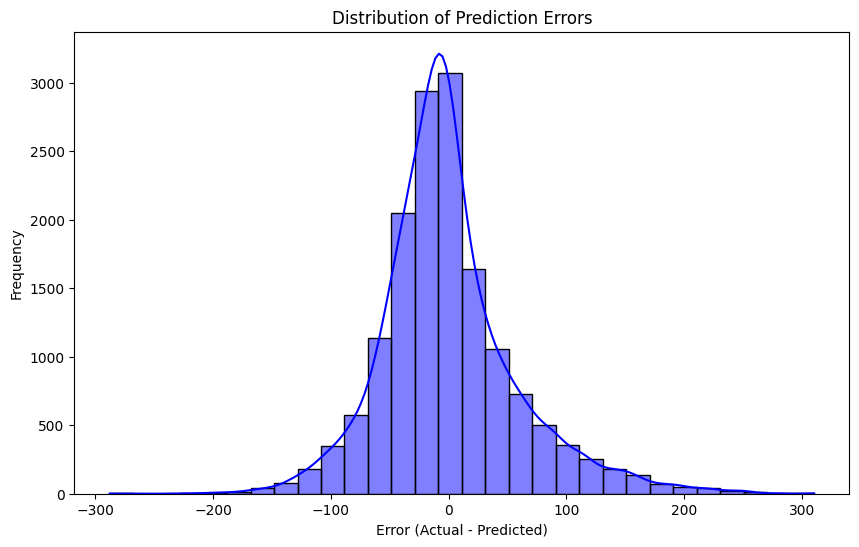

Mean Absolute Error: 41.86
Root Mean Squared Error: 58.15
R² Score: 0.56


In [96]:
# Calculate residuals (errors)
errors = y_test - y_pred

# Create a dataframe
errors_df = pd.DataFrame({'Error': errors})

# Plot the distribution of errors
plt.figure(figsize=(10, 6))
sns.histplot(errors_df['Error'], kde=True, bins=30, color='blue')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

## 4. Export Model
#### 4.1 Save the model locally

In [97]:
# Save the model locally
dump(best_model, 'model_h3.joblib')

['model_h3.joblib']

#### 4.2 Upload the model to AWS S3

In [98]:
# boto3 will initialize connection using environment variables
s3 = boto3.resource('s3')

In [99]:
bucket_name = 'airbnb-capstone-project'
file_name = 'model_h3.joblib'
s3_file_name = 'models/model_h3.joblib'

# Initialize S3 client
s3 = boto3.client('s3')

try:
    # Upload the file
    s3.upload_file(file_name, bucket_name, s3_file_name)
    print(f"Model saved and uploaded successfully to s3://{bucket_name}/{s3_file_name}")
except FileNotFoundError:
    print(f"The file {file_name} was not found.")

Model saved and uploaded successfully to s3://airbnb-capstone-project/models/model_h3.joblib
